# **Apprendimento Supervisionato**

### **Import delle dipendenze**
    Importazione delle librerie utilizzate

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import time
import warnings
from IPython.display import Markdown
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
)
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import SVR, LinearSVR

# Configurazioni di stile e opzioni di visualizzazione
sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.options.mode.chained_assignment = None

# Ignora i warning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Funzione per visualizzare testo in grassetto
def bold(string):
    display(Markdown("**" + string + "**"))



### **Funzioni:** *Utils*

    - caricare il dataset

In [9]:
datadir = '../data/processed/Preprocessed_dataset_completo.csv'

def load_dataset(path, variance_threshold=0.90):
    # Carica il dataset
    dataset = pd.read_csv(path, engine='python', on_bad_lines='skip')
    
    # Drop delle colonne non utili
    dataset = dataset.drop(columns=['name', 'publisher', 'developer'])
    
    # Verifica e gestisci i valori mancanti
    if dataset.isnull().any().any():
        print("Sono presenti valori mancanti nel dataset. Gestione in corso...")
        dataset = dataset.dropna()  # Rimuovi le righe con valori mancanti

    # Inizializza gli encoder per le variabili categoriche
    genre_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    platform_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Applica l'encoding alle colonne categoriche
    genre_encoded_data = genre_encoder.fit_transform(dataset[['genery']])
    platform_encoded_data = platform_encoder.fit_transform(dataset[['platform']])

    # Crea DataFrame dalle colonne codificate
    genre_encoded_data_df = pd.DataFrame(genre_encoded_data, columns=genre_encoder.get_feature_names_out(['genery']))
    platform_encoded_data_df = pd.DataFrame(platform_encoded_data, columns=platform_encoder.get_feature_names_out(['platform']))

    # Rimuovi le colonne categoriche originali e aggiungi quelle codificate
    dataset = dataset.drop(['genery', 'platform'], axis=1)
    dataset = pd.concat([dataset, genre_encoded_data_df, platform_encoded_data_df], axis=1)

    # Applica PCA alle colonne dummy
    # Applica PCA alle colonne dummy
    print("Applicazione della PCA alle colonne dummy...")
    # Seleziona solo le colonne dummy (quelle generate dall'encoding)
    dummy_columns = genre_encoded_data_df.columns.union(platform_encoded_data_df.columns)
    dummy_data = dataset[dummy_columns]
    
    # Applica PCA con varianza cumulativa del 90%
    pca = PCA(n_components=variance_threshold)
    pca_data = pca.fit_transform(dummy_data)
    
    # Crea un DataFrame con i componenti principali
    n_components = pca.n_components_  # Numero di componenti selezionati
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    pca_data_df = pd.DataFrame(pca_data, columns=pca_columns)
    
    # Rimuovi le colonne dummy originali e aggiungi i componenti principali
    dataset = dataset.drop(dummy_columns, axis=1)
    dataset = pd.concat([dataset, pca_data_df], axis=1)

    dataset.to_csv('../data/intermediates/dumming.csv')
    # Separa la variabile target dalle altre
    y = dataset["user_score"]
    X = dataset.drop(['user_score'], axis=1)
    
    # Converti la variabile target in float e verifica la presenza di valori non validi
    try:
        y = y.astype(float)
    except ValueError as e:
        print("Errore nella conversione della variabile target:", e)
        return None, None, None, None
    
    # Divide il dataset in training e test set (con stratificazione se necessario)
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=42, stratify=None)

    # Stampa informazioni di debug
    print("Dimensioni del dataset originale:", dataset.shape)
    print("Dimensioni del training set:", xTrain.shape)
    print("Dimensioni del test set:", xTest.shape)
    
    return xTrain, yTrain, xTest, yTest


    - visualizzare i risultati

In [10]:
# funzione che visualizza il grafico deo risultati ottenuti
def showRegressionResults(r2,mse,mae,y_test, y_pred, model_name): 
    # Stampa delle metriche
    print("Regression Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R2): {r2:.2f}")
    
    
    # Visualizzazione dei risultati
    plt.figure(figsize=(10, 6))
    
    # Grafico a dispersione tra valori reali e predetti
    sns.regplot(x=y_test, y=y_pred)
    plt.xlabel('True User Score')
    plt.ylabel('Predicted User Score')
    plt.title(f'Model: {model_name}')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Funzione per generare i plot
def plot_results(results_df):
    plt.figure(figsize=(10, 8))  # Dimensioni della figura
    
    # Metriche da plottare
    metrics = ["R2", "MSE", "MAE"]
    titles = ["metric: Coefficiente di determinazione", "metric: Mean Squared Error", "metric: Mean Absolute Error "]
    
    # Creazione dei subplot
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        plt.subplot(3, 1, i+1)  # 3 righe, 1 colonna
        ax = sns.barplot(data=results_df, x=results_df.index, y=metric, palette='viridis')
        
        # Aggiungi etichette alle barre
        for container in ax.containers:
            ax.bar_label(container, fmt='%.4f', padding=3)  # Formatta i valori con 4 decimali
        
        # Migliora la leggibilità degli assi
        plt.xlabel('')
        plt.ylabel(metric, fontsize=10)
        plt.xticks(rotation=0, fontsize=8)
        plt.yticks(fontsize=12)
        plt.title(title, fontsize=12, pad=20)  # Aggiungi padding al titolo
    
    plt.tight_layout()  # Migliora la spaziatura tra i subplot
    plt.show()

    - normalizza il dataset

In [11]:
# funzione che normalizza i valori del dataset
def standardization(data):
    # Crea una copia del DataFrame per non modificare l'originale
    df = data.copy()
    
    # Inizializza lo scaler
    scaler = MinMaxScaler()

    # Applica la normalizzazione a tutte le colonne del DataFrame
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    return df_normalized

    - salvare i modelli addestrati

In [19]:
#funzione per salvare il modello addrestrato
def save_model(model,name:str):
    # Salva il modello su file
    with open( '../models/save_dir/' + name + '.pkl', 'wb') as file:
        pickle.dump(model, file)

    - Funzioni per:
        - validazione del modello
        - tuning degli iperparametri

In [13]:
# funzione per il tuning e la validazione
def tune_and_evaluate(model, param_grid, xTrain, yTrain):
    # Standardizzazione del dataset
    print('Standardizzazione del dataset...')
    xTrain_std = standardization(xTrain)
    print('FATTO')

    # Ignora i warning di convergenza
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    # Tuning degli iperparametri
    print('Ricerca degli iperparametri ottimali...')
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(xTrain_std, yTrain)
    best_params = grid_search.best_params_
    print('Migliori iperparametri trovati:', best_params)

    # Valutazione del modello con i migliori iperparametri
    print('Valutazione del modello con i migliori iperparametri...')
    model.set_params(**best_params)

    # Metriche di regressione
    scoring = {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'R2': make_scorer(r2_score)
    }

    # Cross-validation
    for metric_name, metric_scorer in scoring.items():
        scores = cross_val_score(
            estimator=model,
            X=xTrain_std,
            y=yTrain,
            cv=10,
            scoring=metric_scorer
        )
        if metric_name == 'R2':
            print(f"{metric_name}: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
        else:
            print(f"{metric_name}: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std()))

    return best_params

#funzione per valutare il modello
def evaluate(model, xTrain, yTrain):
    
    print('Standardizzazione del dataset...')
    xTrain = standardization(xTrain)

    print('FATTO')

    print('Validazione delle prestazioni...')
    warnings.filterwarnings("ignore", category=ConvergenceWarning)  # Sposta fuori dal ciclo

    # Metriche di regressione
    scoring = {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'R2': make_scorer(r2_score)
    }

    # Cross-validation
    for metric_name, metric_scorer in scoring.items():
        scores = cross_val_score(
            estimator=model,
            X=xTrain,
            y=yTrain,
            cv=10,
            scoring=metric_scorer
        )
        if metric_name == 'R2':
            print(f"{metric_name}: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
        else:
            print(f"{metric_name}: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std()))


# Funzione per eseguire il tuning degli iperparametri
def tune_hyperparameters(model, param_grid, xTrain, yTrain):

    print('Standardizzazione del dataset...')
    xTrain = standardization(xTrain)
    print('FATTO')

    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(xTrain, yTrain)
    
    return grid_search.best_params_



    - Funzione per il test

In [14]:
# funzione per testare i modelli 
def test(model, xTrain, yTrain, x_test, y_test, model_name):
    # Training
    start_time = time.time()
    model.fit(xTrain, yTrain)
    train_time = time.time() - start_time
    
    # Testing
    start_time = time.time()
    y_pred = model.predict(x_test)
    test_time = time.time() - start_time
    
    # Calcolo delle metriche
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Creazione di un DataFrame per confrontare i valori reali e predetti
    comparison_df = pd.DataFrame({
        'Valore Reale': y_test,
        'Valore Predetto': y_pred,
        'Differenza': y_test - y_pred
    })
    
    # Risultati
    results = {
        "Model": model_name,
        "Train Time": train_time,
        "Test Time": test_time,
        "R2": r2,
        "MSE": mse,
        "MAE": mae,
    }
    
    # Visualizza i risultati della regressione
    showRegressionResults(r2, mse, mae, y_test, y_pred, model_name)
    
    # Stampa il confronto tra valori reali e predetti
    print("\nConfronto tra valori reali e predetti:")
    print(comparison_df)
    
    # Visualizza le previsioni del modello come istogramma
    plot_predictions(y_test, y_pred, model_name)
    
    # Salva il modello su file
    print('Salvataggio del modello...')
    save_model(model, model_name)
    print(f"Modello salvato con successo come '{model_name}.sav'.")

    return results, y_pred

# funzione pe visualizzare l'istrogramma delle predizioni 
def plot_predictions(y_test, y_pred, model_name):
    """
    Funzione per visualizzare i valori reali e predetti come istogramma.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(y_test, color="blue", label="Valori Reali", kde=True, bins=30, alpha=0.5)
    sns.histplot(y_pred, color="red", label="Valori Predetti", kde=True, bins=30, alpha=0.5)
    plt.xlabel('Valori')
    plt.ylabel('Frequenza')
    plt.title(f'Distribuzione dei Valori Reali e Predetti - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()



    - Funzione per il salvare e caricare gli iperparametri

In [15]:
# Funzione per salvare gli iperparametri in un file
def save_hyperparameters(hyperparameters, filename):
    
    # Costruisci il percorso completo del file
    directory = '../models/iperparametri2/'
    filepath = os.path.join(directory, filename)
    
    # Verifica se la cartella esiste, altrimenti creala
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Salva gli iperparametri
    with open(filepath, 'wb') as file:
        pickle.dump(hyperparameters, file)
    
    print(f"Iperparametri salvati in {filepath}")

# Funzione per caricare gli iperparametri da un file
def load_hyperparameters(filename):
    
    # Costruisci il percorso completo del file
    filepath = os.path.join('../models/iperparametri/', filename)
    
    # Verifica se il file esiste
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Il file {filepath} non esiste.")
    
    # Carica gli iperparametri
    with open(filepath, 'rb') as file:
        hyperparameters = pickle.load(file)
    
    print(f"Iperparametri caricati da {filepath}")
    return hyperparameters

### **Caricamento del dataset**

In [17]:
# Carica il dataset con PCA che mantiene il 90% della varianza
print('Dataset loading...')
xTrain, yTrain, xTest, yTest = load_dataset(datadir, variance_threshold=0.90)
print('DONE')

Dataset loading...
Applicazione della PCA alle colonne dummy...
Dimensioni del dataset originale: (11150, 48)
Dimensioni del training set: (7805, 47)
Dimensioni del test set: (3345, 47)
DONE


## **Base Learners**

### **Selezione dei modelli**
    Rapido test e valutazione dei moddeli di regressione disponibili

In [189]:
models = {}
models['Random Forest'] = RandomForestRegressor()
models['Gradient Boosting'] = GradientBoostingRegressor()
models['Ada Boost'] = AdaBoostRegressor()
models['Ridge'] = Ridge()
models['Lasso'] = Lasso()
models['Linear Regression'] = LinearRegression()
models['Elastic Net'] = ElasticNet()
models['SVR'] = SVR()
models['Linear SVR'] = LinearSVR()
models['LGBM'] = LGBMRegressor(verbose=0)
models['KNN'] = KNeighborsRegressor()

In [190]:
# Definisci il numero di fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

train_time, test_time, r2, a_r2, mse, rmse, mae = {}, {}, {}, {}, {}, {}, {}

for key in models.keys():
    # K-fold cross-validation per il modello corrente
    cv_scores = cross_val_score(models[key], xTrain, yTrain, cv=kf, scoring='r2')
    print(f"{key} - Cross-validation R2 scores: {cv_scores}")
    print(f"{key} - Mean R2 score: {np.mean(cv_scores)}")

    # Addestramento del modello su tutto il training set
    start_time = time.time()
    models[key].fit(xTrain, yTrain)
    end_time = time.time()
    train_time[key] = end_time - start_time

    # Valutazione del modello sul test set
    start_time = time.time()
    y_pred = models[key].predict(xTest)
    end_time = time.time()
    test_time[key] = end_time - start_time

    # Calcolo delle metriche di valutazione
    r2[key] = r2_score(yTest, y_pred)
    
    mse[key] = mean_squared_error(yTest, y_pred)
    mae[key] = mean_absolute_error(yTest, y_pred)
    
    print("#" * 50)

Random Forest - Cross-validation R2 scores: [-0.05689828 -0.08709599 -0.07766123 -0.11331757 -0.13631429]
Random Forest - Mean R2 score: -0.09425747087641705
##################################################
Gradient Boosting - Cross-validation R2 scores: [0.04422774 0.06765014 0.06370994 0.04260605 0.04286474]
Gradient Boosting - Mean R2 score: 0.05221172421186095
##################################################
Ada Boost - Cross-validation R2 scores: [-0.20797902 -0.09644611 -0.17350155 -0.17842861 -0.10724299]
Ada Boost - Mean R2 score: -0.15271965616186872
##################################################
Ridge - Cross-validation R2 scores: [0.00661645 0.01214832 0.01266845 0.01997337 0.01059959]
Ridge - Mean R2 score: 0.012401235507444586
##################################################
Lasso - Cross-validation R2 scores: [0.00665584 0.01216393 0.01267851 0.01989952 0.01060928]
Lasso - Mean R2 score: 0.012401418094740402
##################################################
Lin

In [186]:
base_results_df = pd.DataFrame({"Train Time": train_time.values(),
                                "Test Time": test_time.values(),
                                "R2": r2.values(),
                                "MSE": mse.values(),
                                "MAE": mae.values()}, index=list(models.keys()))

base_results_df

,Train Time,Test Time,R2,MSE,MAE
Random Forest,1.71,0.05,-0.07,1.96,1.05
Gradient Boosting,0.51,0.00,0.06,1.72,0.99
Ada Boost,0.06,0.00,-0.19,2.17,1.23
Ridge,0.00,0.00,-0.03,1.87,1.02
Lasso,0.00,0.00,-0.03,1.87,1.02
Linear Regression,0.00,0.00,-0.03,1.87,1.02
Elastic Net,0.00,0.00,-0.03,1.87,1.02
SVR,0.96,0.83,-0.02,1.86,0.96
Linear SVR,0.12,0.00,-39.60,74.04,2.09
LGBM,0.04,0.00,0.05,1.73,0.98


la verifica dei modelli candidati ha prodotto queste considerazioni:

- modelli da evitarre:
    - Linear SVR: Ha un R2 negativo, il che indica che è un modello inadatto per questi dati.
    - Ada Boost, Lasso, Elastic Net, KNN: Hanno prestazioni inferiori non aggiungono molta diversità.

- modelli idoenei per lo stacking:
    -   Random Forest, LGBM, e Gradient Boosting sono i più performanti.
    -   altri modelli per diversificare l'approccio:
        -   Ridge Regression e SVR 


### **Modelli selezionati**
    Funzioni per la creazione dei base learn Regressori che verranno utilizzati

In [1]:
#------------------------------------- Base Learns -------------------------------------------

# -------------------------------- RANDOM FOREST REGRESSOR ---------------------
RFRW_params = {
    'n_estimators': 200,
    'max_depth': None,
    'random_state': 0
}

def RandomForestRegressorWrapper(params):
    model = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        random_state=params['random_state']
    )
    return model

# -------------------------------- GRADIENT BOOSTING REGRESSOR -----------------
GBRW_params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 3,
    'random_state': 0
}

def GradientBoostingRegressorWrapper(params):
    model = GradientBoostingRegressor(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        random_state=params['random_state']
    )
    return model
# -------------------------------- RIDGE REGRESSOR -----------------
Ridge_params = {
    'alpha': 1.0,
    'random_state': 0
}

def RidgeRegressorWrapper(params):
    model = Ridge(
        alpha=params['alpha'],
        random_state=params['random_state']
    )
    return model

# -------------------------------- SupportVectorRegressorWrapper --------------------
SVR_params = {
    'kernel': 'rbf',
    'C': 10,
    'degree': 6,
    'gamma': 'auto'
}

def SupportVectorRegressorWrapper(params):
    model = SVR(
        kernel=params['kernel'],
        C=params['C'],
        degree=params['degree'],
        gamma=params['gamma']
    )
    return model


### **Fase di ricerca degli iperparametri e Validazione**

In [160]:

# Lista di modelli e griglie di iperparametri corrispondenti
models = [
    {
        'name': 'Random Forest Regressor',
        'model': RandomForestRegressorWrapper(RFRW_params),  
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10, 15],
            'random_state': [0]
        },
        'filename': 'random_forest_params.pkl'  
    },
    {
        'name': 'Gradient Boosting Regressor',
        'model': GradientBoostingRegressorWrapper(GBRW_params),  
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'random_state': [0]
        },
        'filename': 'gradient_boosting_params.pkl'  
    },
    {
        'name': 'Ridge Regressor',
        'model': RidgeRegressorWrapper(Ridge_params),  
        'param_grid': {
            'alpha': [0.1, 1.0, 10.0],
            'random_state': [0]
        },
        'filename': 'ridge_params.pkl'  
    },
    {
        'name': 'Support Vector Regressor',
        'model': SupportVectorRegressorWrapper(SVR_params),  
        'param_grid': {
            'kernel': ['rbf', 'sigmoid'],
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto'],
            'degree': [2, 3, 4, 5, 6]
        },
        'filename': 'svr_params.pkl'  
    }
]

# Itera sui modelli
for model_info in models:
    print(f"\nTuning e valutazione del modello: {model_info['name']}")
    best_params = tune_and_evaluate(
        model=model_info['model'],
        param_grid=model_info['param_grid'],
        xTrain=xTrain,
        yTrain=yTrain
    )
    print(f"Migliori iperparametri per {model_info['name']}: {best_params}")
    
    # Salva gli iperparametri trovati
    save_hyperparameters(best_params, model_info['filename'])
    
    print("-" * 50)


Tuning e valutazione del modello: Random Forest Regressor
Standardizzazione del dataset...
FATTO
Ricerca degli iperparametri ottimali...
Migliori iperparametri trovati: {'max_depth': None, 'n_estimators': 300, 'random_state': 0}
Valutazione del modello con i migliori iperparametri...
MSE: 1.09 (+/- 0.06)
MAE: 0.77 (+/- 0.02)
R2: 0.41 (+/- 0.04)
Migliori iperparametri per Random Forest Regressor: {'max_depth': None, 'n_estimators': 300, 'random_state': 0}
Iperparametri salvati in ../models/iperparametri/random_forest_params.pkl
--------------------------------------------------

Tuning e valutazione del modello: Gradient Boosting Regressor
Standardizzazione del dataset...
FATTO
Ricerca degli iperparametri ottimali...
Migliori iperparametri trovati: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'random_state': 0}
Valutazione del modello con i migliori iperparametri...
MSE: 1.12 (+/- 0.06)
MAE: 0.77 (+/- 0.02)
R2: 0.40 (+/- 0.05)
Migliori iperparametri per Gradient Boosting

### **Fase di test dei modelli**


    carimaneto degli iperparametri

In [22]:
# Carica gli iperparametri
loaded_params_rf = load_hyperparameters('random_forest_params.pkl')
loaded_params_gb = load_hyperparameters('gradient_boosting_params.pkl')
loaded_params_ridge = load_hyperparameters('ridge_params.pkl')
loaded_params_svr = load_hyperparameters('svr_params.pkl')

# Stampa tutti gli iperparametri caricati
print("Iperparametri Random Forest caricati:", loaded_params_rf)
print("Iperparametri Gradient Boosting caricati:", loaded_params_gb)
print("Iperparametri Ridge Regression caricati:", loaded_params_ridge)
print("Iperparametri SVR caricati:", loaded_params_svr)


Iperparametri caricati da ../models/iperparametri/random_forest_params.pkl
Iperparametri caricati da ../models/iperparametri/gradient_boosting_params.pkl
Iperparametri caricati da ../models/iperparametri/ridge_params.pkl
Iperparametri caricati da ../models/iperparametri/svr_params.pkl
Iperparametri Random Forest caricati: {'max_depth': None, 'n_estimators': 300, 'random_state': 0}
Iperparametri Gradient Boosting caricati: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'random_state': 0}
Iperparametri Ridge Regression caricati: {'alpha': 0.1, 'random_state': 0}
Iperparametri SVR caricati: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


    test dei modelli 

Modello Random_Forest_Regressor:
Regression Metrics:
Mean Squared Error (MSE): 0.94
Mean Absolute Error (MAE): 0.71
R-squared (R2): 0.44


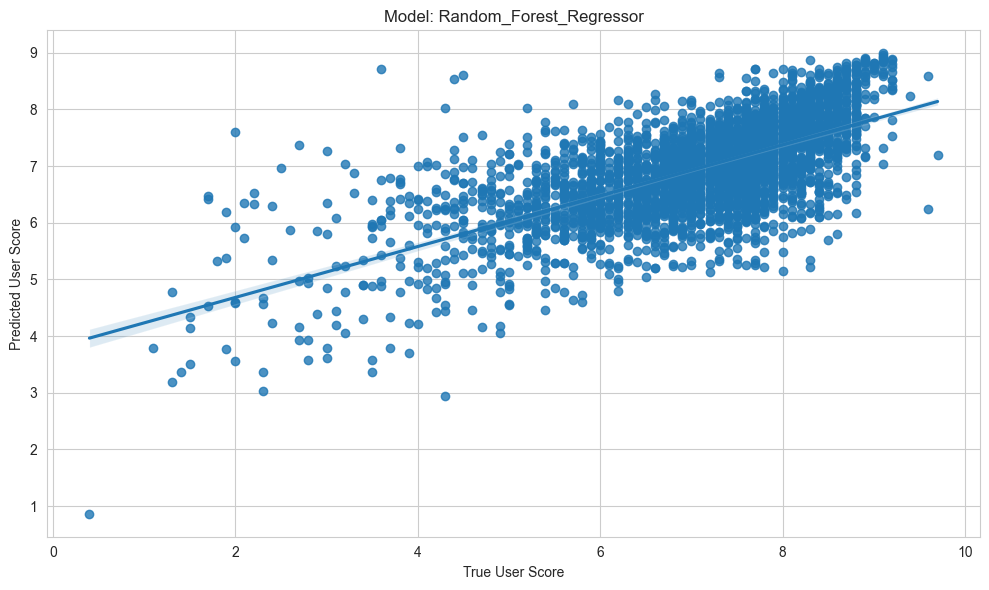


Confronto tra valori reali e predetti:
       Valore Reale  Valore Predetto  Differenza
9271           6.00             6.94       -0.94
2874           7.70             7.79       -0.09
2174           8.50             6.85        1.65
1744           8.70             7.64        1.06
4192           8.80             8.35        0.45
...             ...              ...         ...
10995          4.70             5.18       -0.48
3145           7.90             6.70        1.20
4609           6.70             7.61       -0.91
4913           7.50             7.12        0.38
5331           7.50             6.58        0.92

[3345 rows x 3 columns]


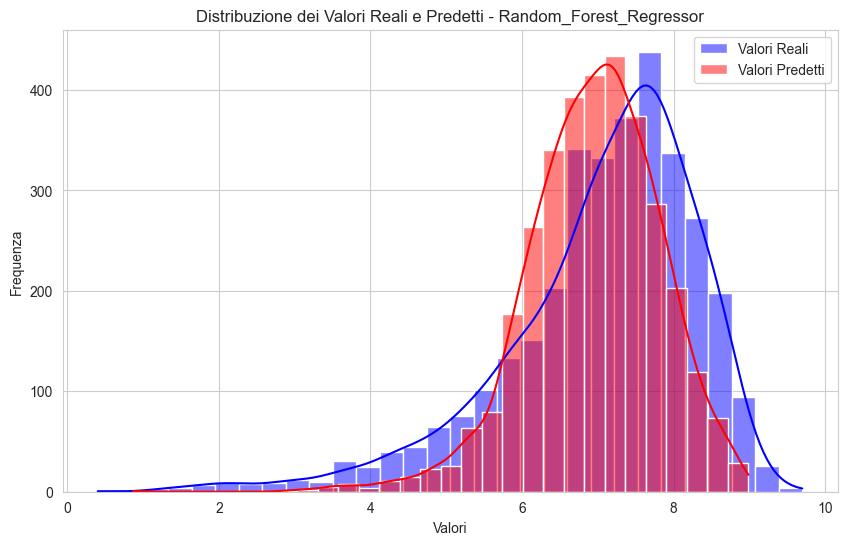

Salvataggio del modello...
Modello salvato con successo come 'Random_Forest_Regressor.sav'.
Risultati per Random_Forest_Regressor: ({'Model': 'Random_Forest_Regressor', 'Train Time': 24.900125980377197, 'Test Time': 0.1028285026550293, 'R2': 0.4433686725346032, 'MSE': 0.9399204184916785, 'MAE': 0.714826521104705}, array([6.94  , 7.7925, 6.855 , ..., 7.6145, 7.1195, 6.577 ], shape=(3345,)))

Modello Gradient_Boosting_Regressor:
Regression Metrics:
Mean Squared Error (MSE): 1.06
Mean Absolute Error (MAE): 0.75
R-squared (R2): 0.37


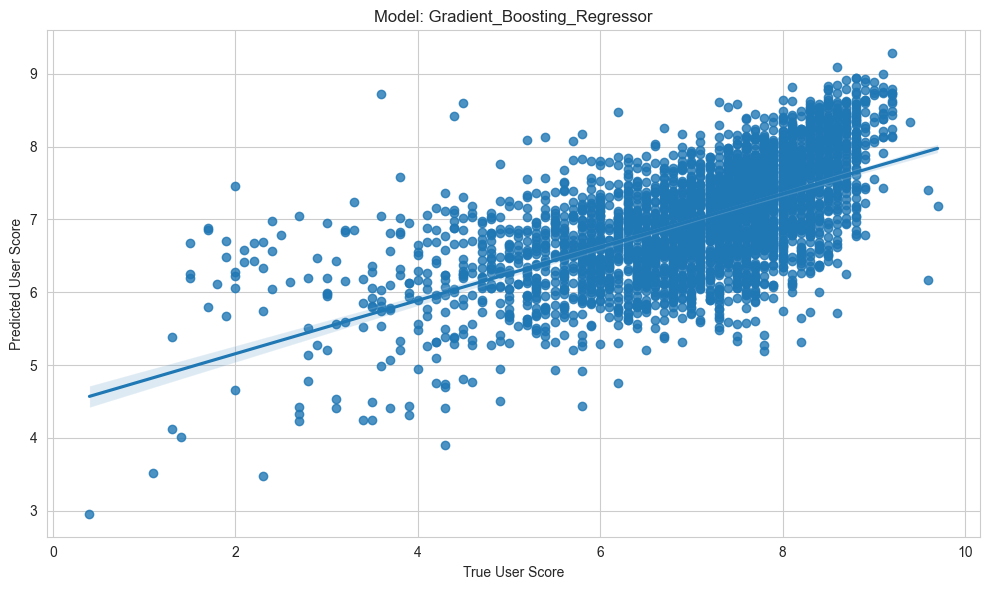


Confronto tra valori reali e predetti:
       Valore Reale  Valore Predetto  Differenza
9271           6.00             7.17       -1.17
2874           7.70             7.97       -0.27
2174           8.50             7.34        1.16
1744           8.70             7.60        1.10
4192           8.80             8.07        0.73
...             ...              ...         ...
10995          4.70             5.90       -1.20
3145           7.90             6.98        0.92
4609           6.70             7.69       -0.99
4913           7.50             6.98        0.52
5331           7.50             6.34        1.16

[3345 rows x 3 columns]


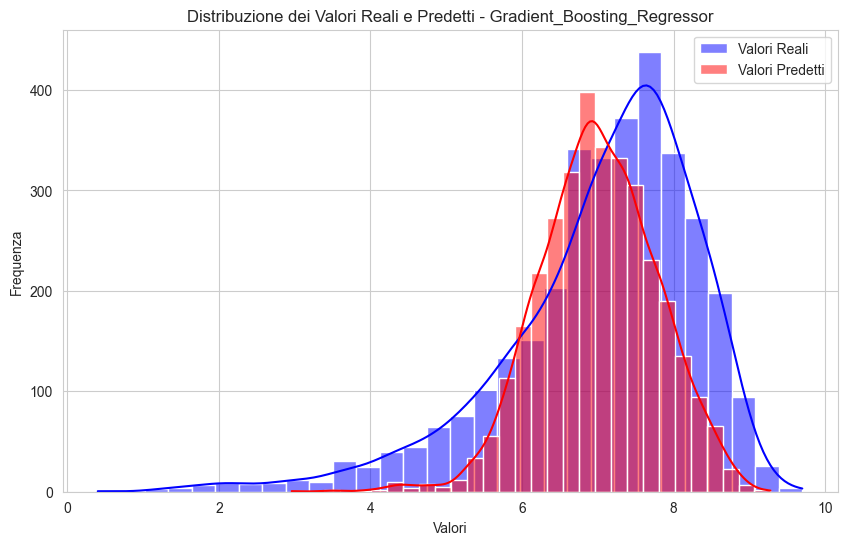

Salvataggio del modello...
Modello salvato con successo come 'Gradient_Boosting_Regressor.sav'.
Risultati per Gradient_Boosting_Regressor: ({'Model': 'Gradient_Boosting_Regressor', 'Train Time': 4.735135078430176, 'Test Time': 0.007286548614501953, 'R2': 0.3737840138364096, 'MSE': 1.0574201679614434, 'MAE': 0.7516615510628372}, array([7.17012218, 7.9732046 , 7.33669604, ..., 7.69227459, 6.97615023,
       6.34203594], shape=(3345,)))

Modello Ridge_Regressor:
Regression Metrics:
Mean Squared Error (MSE): 1.49
Mean Absolute Error (MAE): 0.89
R-squared (R2): 0.12


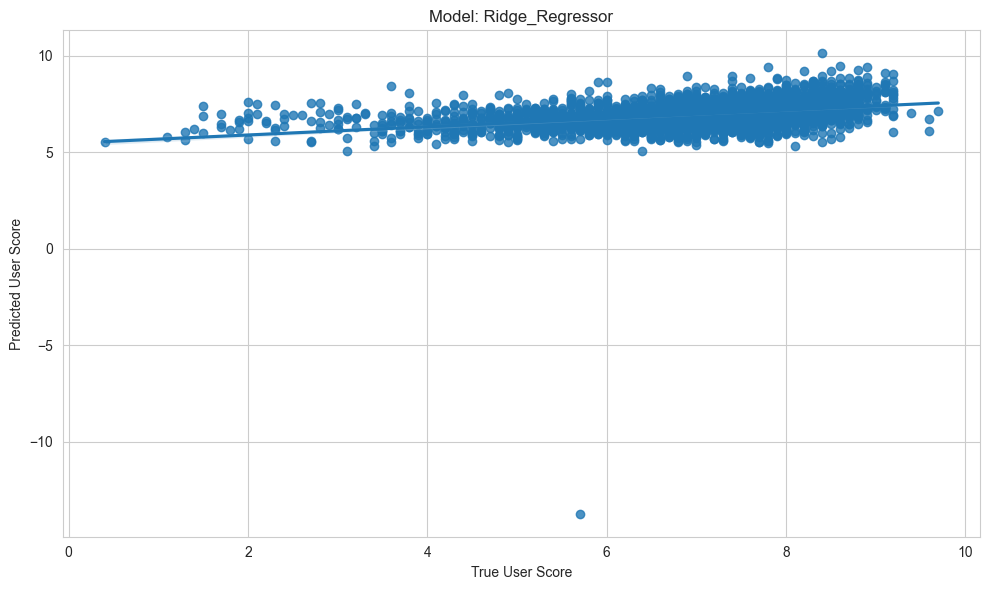


Confronto tra valori reali e predetti:
       Valore Reale  Valore Predetto  Differenza
9271           6.00             6.95       -0.95
2874           7.70             8.03       -0.33
2174           8.50             7.65        0.85
1744           8.70             7.40        1.30
4192           8.80             7.95        0.85
...             ...              ...         ...
10995          4.70             6.52       -1.82
3145           7.90             6.60        1.30
4609           6.70             7.55       -0.85
4913           7.50             6.96        0.54
5331           7.50             6.43        1.07

[3345 rows x 3 columns]


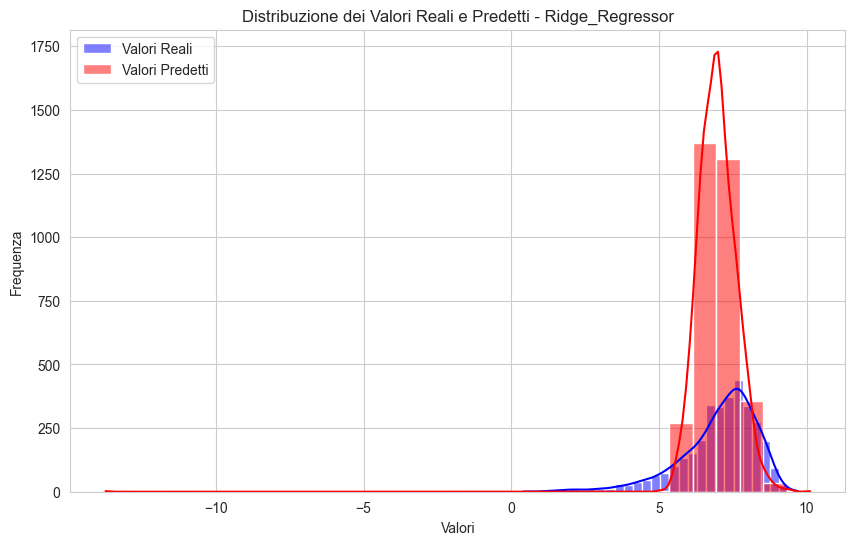

Salvataggio del modello...
Modello salvato con successo come 'Ridge_Regressor.sav'.
Risultati per Ridge_Regressor: ({'Model': 'Ridge_Regressor', 'Train Time': 0.0035469532012939453, 'Test Time': 0.0009276866912841797, 'R2': 0.11948846015684245, 'MSE': 1.4868203318426805, 'MAE': 0.8881959810165327}, array([6.95348613, 8.02705792, 7.65173092, ..., 7.55090841, 6.9644507 ,
       6.429961  ], shape=(3345,)))

Modello Support_Vector_Regressor:
Regression Metrics:
Mean Squared Error (MSE): 1.60
Mean Absolute Error (MAE): 0.98
R-squared (R2): 0.05


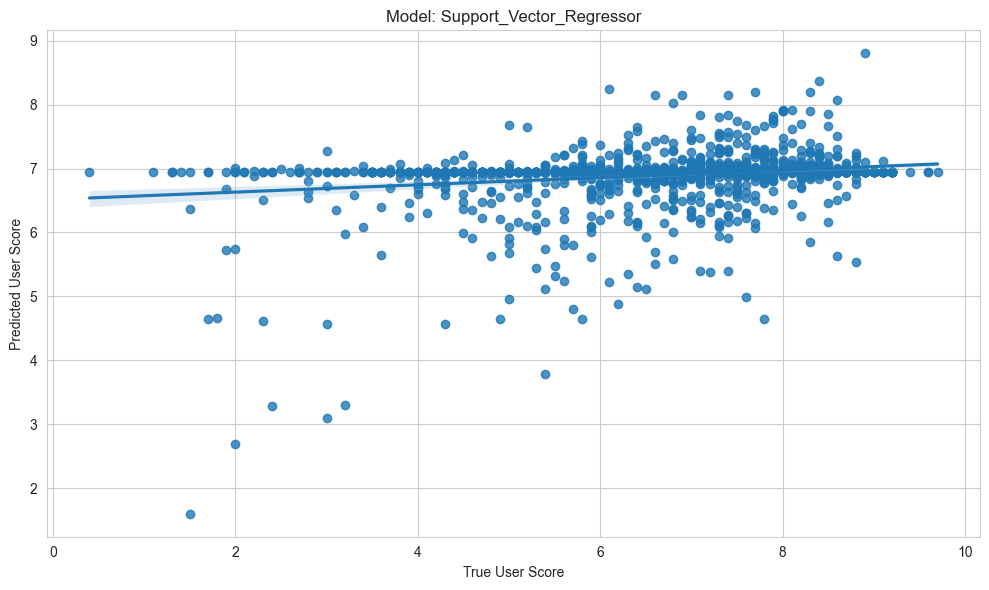


Confronto tra valori reali e predetti:
       Valore Reale  Valore Predetto  Differenza
9271           6.00             6.95       -0.95
2874           7.70             7.02        0.68
2174           8.50             6.95        1.55
1744           8.70             6.95        1.75
4192           8.80             6.95        1.85
...             ...              ...         ...
10995          4.70             6.95       -2.25
3145           7.90             6.95        0.95
4609           6.70             6.95       -0.25
4913           7.50             6.95        0.55
5331           7.50             6.95        0.55

[3345 rows x 3 columns]


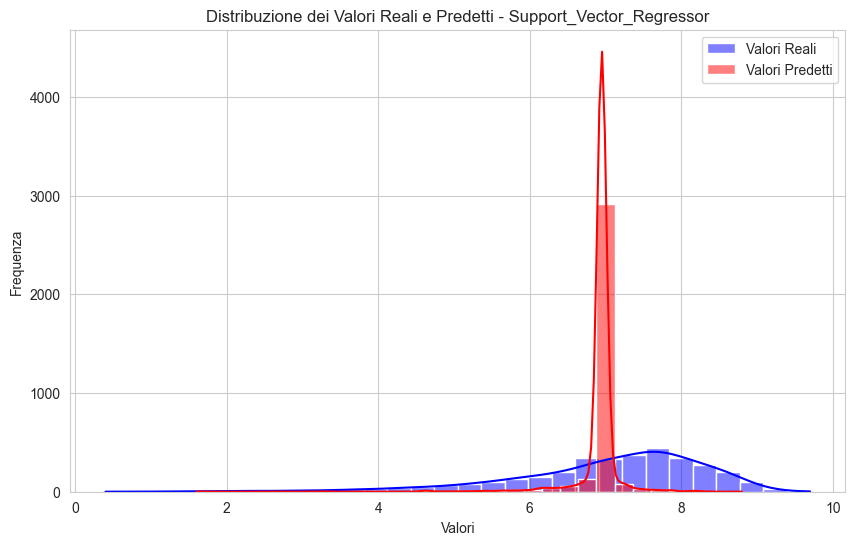

Salvataggio del modello...
Modello salvato con successo come 'Support_Vector_Regressor.sav'.
Risultati per Support_Vector_Regressor: ({'Model': 'Support_Vector_Regressor', 'Train Time': 3.646496057510376, 'Test Time': 1.3046786785125732, 'R2': 0.04983420895339297, 'MSE': 1.6044375943115103, 'MAE': 0.9832422133516466}, array([6.95049251, 7.02418674, 6.95055571, ..., 6.9504925 , 6.9504925 ,
       6.9504925 ], shape=(3345,)))



In [18]:
# Lista dei modelli da testare
models_to_test = [
    {
        'name': 'Random_Forest_Regressor',
        'wrapper': RandomForestRegressorWrapper,
        'params': RFRW_params
    },
    {
        'name': 'Gradient_Boosting_Regressor',
        'wrapper': GradientBoostingRegressorWrapper,
        'params': GBRW_params
    },
    {
        'name': 'Ridge_Regressor',
        'wrapper': RidgeRegressorWrapper,
        'params': Ridge_params
    },
    {
        'name': 'Support_Vector_Regressor',
        'wrapper': SupportVectorRegressorWrapper,
        'params': SVR_params
    }
]

# Lista per memorizzare i risultati
results = []

# Itera sui modelli e testali
for model_info in models_to_test:
    print(f"Modello {model_info['name']}:")
    model = model_info['wrapper'](model_info['params'])  # Crea il modello
    result = test(model, xTrain, yTrain, xTest, yTest, model_info['name'])  # Esegui il test
    results.append(result)  # Aggiungi il risultato alla lista
    print(f"Risultati per {model_info['name']}: {result}\n")

### **Confronto dei modelli Base Learners**

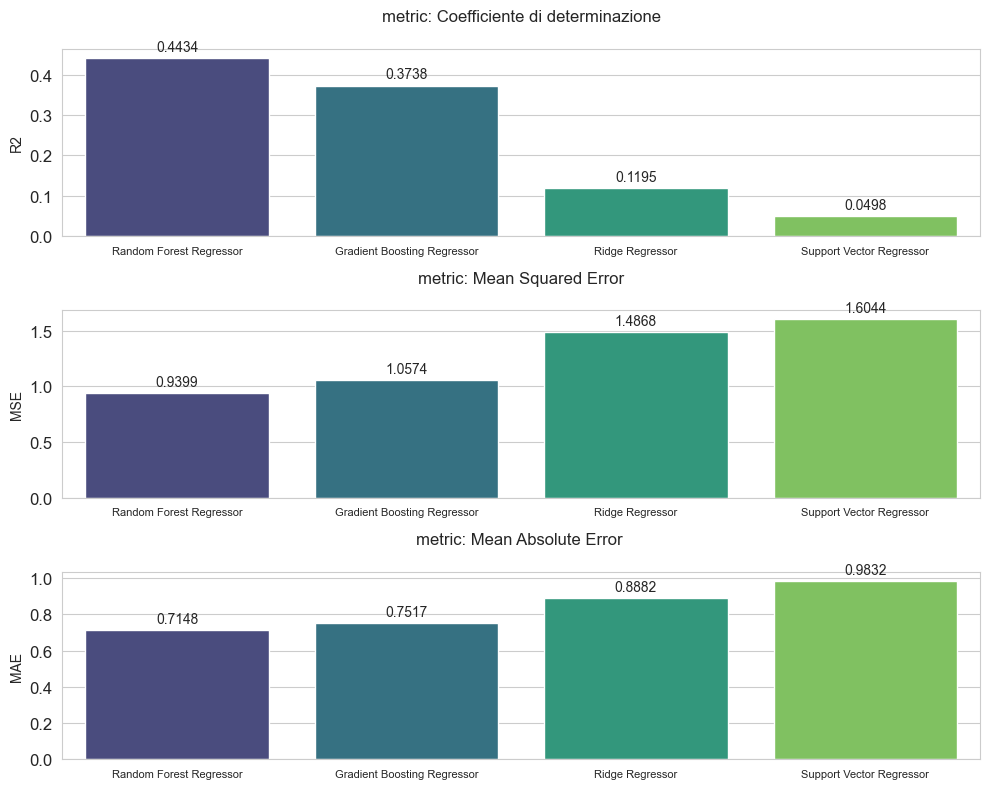

In [158]:
# Creazione del DataFrame con i risultati
base_results_df = pd.DataFrame(results)

# Imposta l'indice del DataFrame con i nomi dei modelli
base_results_df.set_index('Model', inplace=True)

# Genera i plot
plot_results(base_results_df)

## **Stacking**

    Lo stacking è una tecnica che combina le previsioni di più modelli (detti "modelli di base") utilizzando un altro modello (detto "meta-modello") per fare la previsione finale. Il meta-modello impara a pesare le previsioni dei modelli di base per minimizzare l'errore.

### **Meta modelli scelti**
    Funzioni per la creazione dei meta learn Regressori che verranno utilizzati

In [20]:
#----------------------------------- meta model ----------------------------------------------------

# -------------------------------- LinearRegressorWrapper ----------------------------
def LinearRegressorWrapper():
    model = LinearRegression()
    return model

# -------------------------------- NEURAL NETWORK REGRESSION -------------------
NN_params = {
    'hidden_layer_sizes': (100,),  
    'activation': 'relu',          
    'solver': 'adam',              
    'alpha': 0.0001,
    'learning_rate_init': 0.001,
    'early_stopping': True
}

def NeuralNetworkRegressorWrapper(params):
    model = MLPRegressor(
        hidden_layer_sizes=params['hidden_layer_sizes'],
        activation=params['activation'],
        solver=params['solver'],
        random_state=42,
        max_iter=1000,
        alpha=params['alpha'],
        learning_rate_init=params['learning_rate_init'],
        early_stopping=params['early_stopping']
    )
    return model

### **Fase di ricerca degli iperparametri e Validazione per i meta learns**
    - meta_modelli: Neural Network Regressor

In [163]:

# Lista di modelli e griglie di iperparametri corrispondenti
models = [
    {
        'name': 'Neural Network Regressor',
        'model': NeuralNetworkRegressorWrapper(NN_params),  # Modello con parametri predefiniti
        'param_grid': {
            'hidden_layer_sizes': [(100,), (100, 50), (200, 100)],  # Configurazioni degli strati nascosti
            'activation': ['relu', 'tanh'],  # Funzioni di attivazione
            'solver': ['adam', 'sgd'],
            'alpha': [0.0001, 0.001, 0.01],  # Termine di regolarizzazione L2
            'learning_rate_init': [0.001, 0.0001],  # Tasso di apprendimento iniziale
            'early_stopping': [True, False] # Arresto anticipato
        },
        'filename': 'nn_params.pkl'  # Nome del file per salvare gli iperparametri
    }
]

# Itera sui modelli
for model_info in models:
    print(f"\nTuning e valutazione del modello: {model_info['name']}")
    best_params = tune_hyperparameters(
        model=model_info['model'],
        param_grid=model_info['param_grid'],
        xTrain=xTrain,
        yTrain=yTrain
    )
    print(f"Migliori iperparametri per {model_info['name']}: {best_params}")
    
    # Salva gli iperparametri trovati
    save_hyperparameters(best_params, model_info['filename'])
    
    print("-" * 50)


Tuning e valutazione del modello: Neural Network Regressor
Standardizzazione del dataset...
FATTO
Migliori iperparametri per Neural Network Regressor: {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'adam'}
Iperparametri salvati in ../models/iperparametri/nn_params.pkl
--------------------------------------------------


### **Fase di Validazione per i modelli che utilizzano il metodo stacking**

    caricamento degli iperparametri

In [23]:
# Carica gli iperparametri
loaded_params_nnr = load_hyperparameters('nn_params.pkl')

# Stampa tutti gli iperparametri caricati
print("Iperparametri Ridge Regression caricati:", loaded_params_nnr)


Iperparametri caricati da ../models/iperparametri/nn_params.pkl
Iperparametri Ridge Regression caricati: {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'adam'}


    definizione dei base learners e meta learners

In [26]:
# Definizione dei modelli di base
base_models = [
    ('random_forest', RandomForestRegressorWrapper(loaded_params_rf)),
    ('gradient_boosting', GradientBoostingRegressorWrapper(loaded_params_gb)),
    ('ridge', RidgeRegressorWrapper(loaded_params_ridge)),
    ('svr', SupportVectorRegressorWrapper(loaded_params_svr))
]

meta_models = [
    {
        'name': 'Linear_Regressor',
        'model': LinearRegressorWrapper(),
    },
    {
        'name': 'Neural_Network_Regressor',
        'model': NeuralNetworkRegressorWrapper(loaded_params_nnr),
    }
]


    validazione dei modelli

In [138]:
# validazione dei modelli di stacking
for meta_model in meta_models:
    print(f"\nTest del modello di stacking con meta-modello: {meta_model['name']}")
    stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model['model'])
    evaluate(stacking_regressor,xTrain,yTrain)


Test del modello di stacking con meta-modello: Linear Regressor
Standardizzazione del dataset...
FATTO
Validazione delle prestazioni...
MSE: 1.08 (+/- 0.06)
MAE: 0.75 (+/- 0.02)
R2: 0.42 (+/- 0.04)

Test del modello di stacking con meta-modello: Neural Network Regressor
Standardizzazione del dataset...
FATTO
Validazione delle prestazioni...
MSE: 1.09 (+/- 0.06)
MAE: 0.77 (+/- 0.03)
R2: 0.41 (+/- 0.05)


### **Fase di test dei modelli he utilizzano il metodo stacking**

    test dei modelli


Test del modello di stacking con meta-modello: Linear_Regressor
Regression Metrics:
Mean Squared Error (MSE): 0.92
Mean Absolute Error (MAE): 0.70
R-squared (R2): 0.45


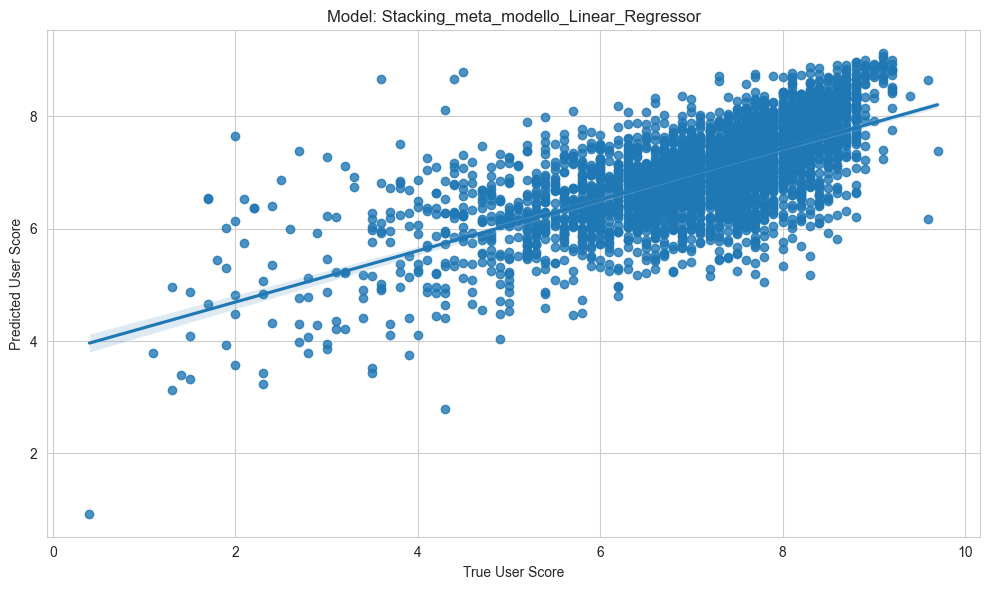


Confronto tra valori reali e predetti:
       Valore Reale  Valore Predetto  Differenza
9271           6.00             6.95       -0.95
2874           7.70             7.88       -0.18
2174           8.50             6.99        1.51
1744           8.70             7.71        0.99
4192           8.80             8.38        0.42
...             ...              ...         ...
10995          4.70             5.41       -0.71
3145           7.90             6.84        1.06
4609           6.70             7.62       -0.92
4913           7.50             7.15        0.35
5331           7.50             6.45        1.05

[3345 rows x 3 columns]


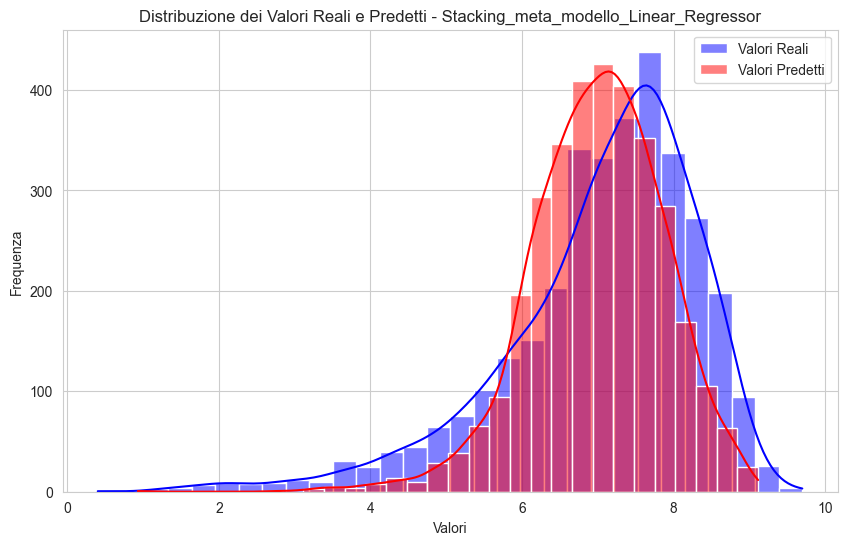

Salvataggio del modello...
Modello salvato con successo come 'Stacking_meta_modello_Linear_Regressor.sav'.

Test del modello di stacking con meta-modello: Neural_Network_Regressor
Regression Metrics:
Mean Squared Error (MSE): 0.93
Mean Absolute Error (MAE): 0.70
R-squared (R2): 0.45


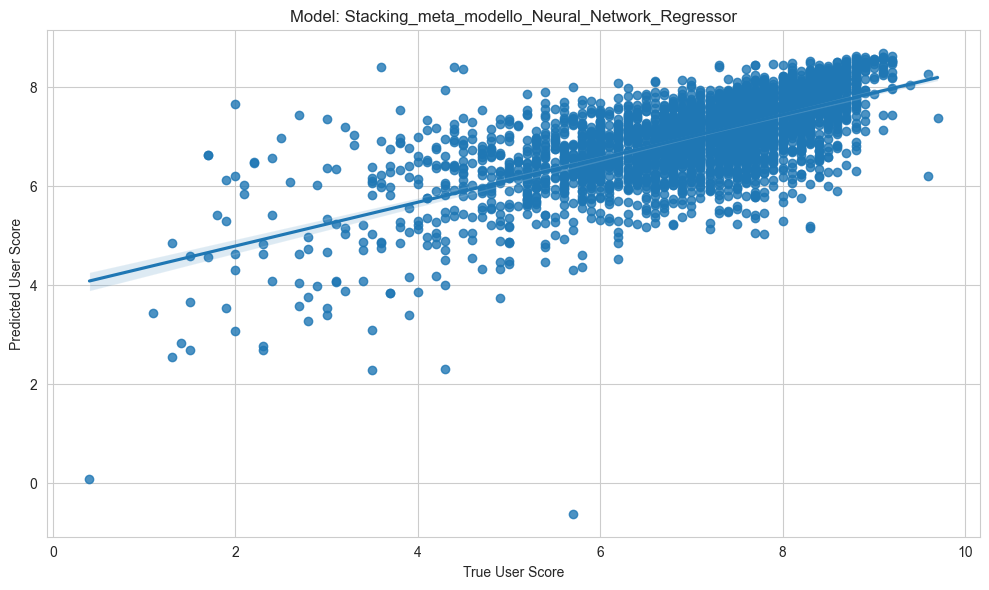


Confronto tra valori reali e predetti:
       Valore Reale  Valore Predetto  Differenza
9271           6.00             7.08       -1.08
2874           7.70             7.85       -0.15
2174           8.50             7.07        1.43
1744           8.70             7.70        1.00
4192           8.80             8.23        0.57
...             ...              ...         ...
10995          4.70             5.37       -0.67
3145           7.90             6.92        0.98
4609           6.70             7.65       -0.95
4913           7.50             7.26        0.24
5331           7.50             6.59        0.91

[3345 rows x 3 columns]


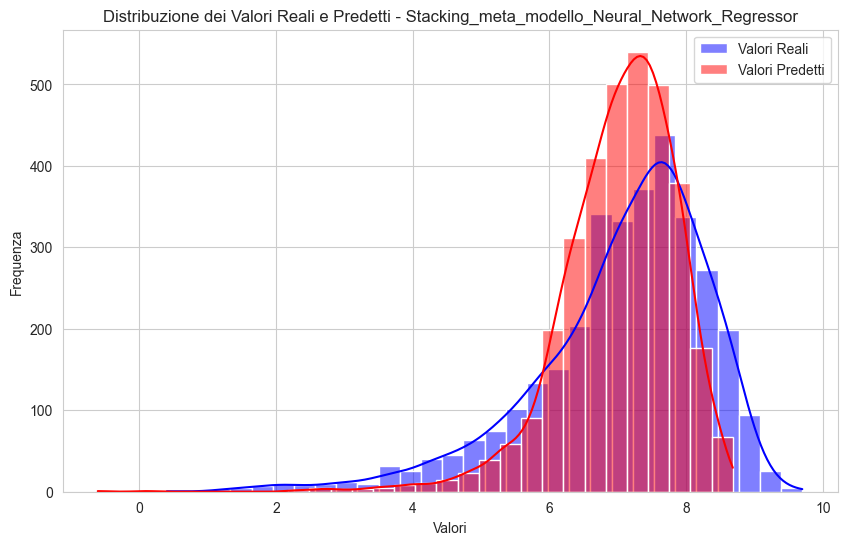

Salvataggio del modello...
Modello salvato con successo come 'Stacking_meta_modello_Neural_Network_Regressor.sav'.


In [27]:
# Lista per memorizzare i risultati dei modelli di stacking
result_stacking = []
result_pred =[]

# Test dei modelli di stacking
for meta_model in meta_models:
    print(f"\nTest del modello di stacking con meta-modello: {meta_model['name']}")
    
    # Creazione del modello di stacking
    stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model['model'])
    
    # Esecuzione del test e memorizzazione dei risultati
    results,pred = test(stacking_regressor, xTrain, yTrain, xTest, yTest, f"Stacking_meta_modello_{meta_model['name']}")
    
    # Aggiungi i risultati alla lista
    result_stacking.append(results)
    result_pred.append(pred)


### **Confronto dei modelli di stacking**

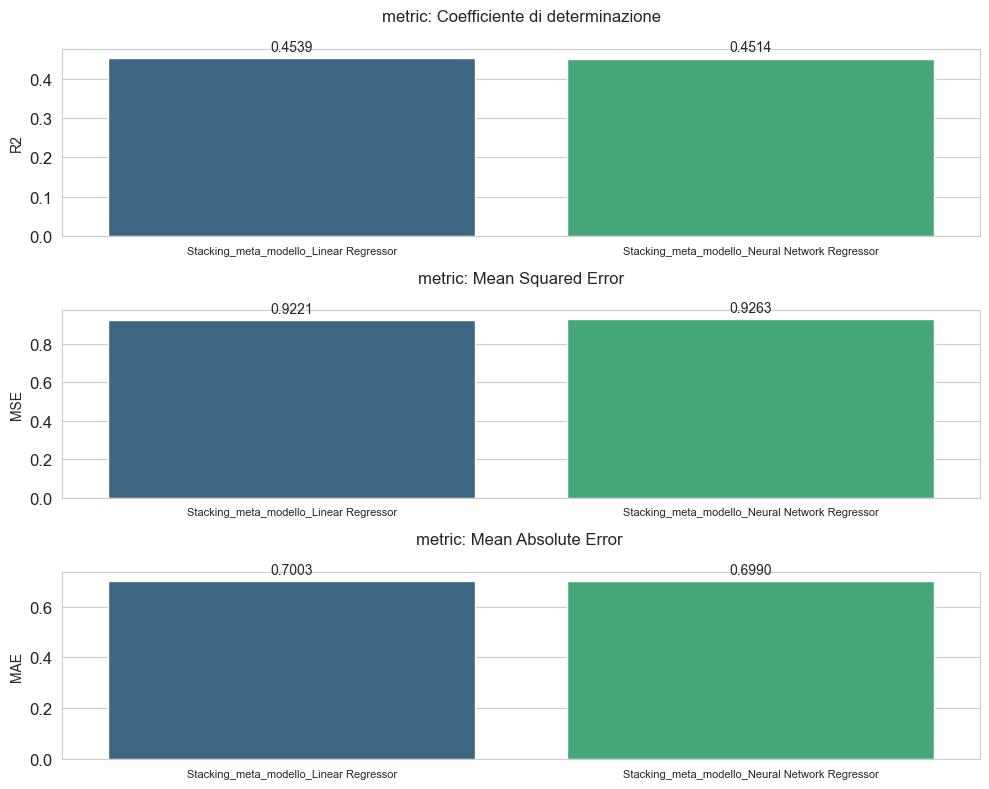

In [146]:
# Creazione del DataFrame con i risultati
base_results_df = pd.DataFrame(result_stacking)

# Imposta l'indice del DataFrame con i nomi dei modelli
base_results_df.set_index('Model', inplace=True)

# Genera i plot
plot_results(base_results_df)